# Trabalho Prático 1
## Criação e Treino de *Convolutionals Neurals Networks* (CNNs)

### Imports Globais

<br/>

Todos os restantes imports serão feitos nas secções que assim os exigem.

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import re
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from PIL import Image

### Variáveis Globais

<br/>

O do **batchSize** é um parâmetro importante quando se treina uma Rede, podendo influenciar a velocidade e a generalização, não necessariamente na mesma direção. Através de algumas pesquisar o grupo decidiu manter o valor padrão, já que não notamos qualquer influência significativa nos resultados obtidos.

1. **imgSize** Tamanho da Imagem a ser usado na criação do Modelo CNN
2. **batchSize** Número de Amostras a ser propagadas pela CNN

Para o *Training* acabamos apenas por usar uma Rede, tendo em conta os resultados positivos para a *accuracy*. No entanto, todo o projeto está adpatado para operar com um número de *Nets* maior. Nesse caso, apenas é preciso alterar o valor desta variável global, ficando o projeto funcional para essa configuração.

**Note-se que caso se use mais do que uma Rede, todo o processo de treino é executado para cada uma das mesmas, tornando-se o treino mais demorado consoante a escolha.**

3. **nets** Número de Redes usadas para *Training*

In [2]:
imgSize = 32
batchSize = 32
nets = 1
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Funções Auxiliares

<br/>

Funções auxiliar já existentes no código inicialmente fornecido pelo docente.
Estas funções são importantes quando se está a carregar todo o lote de imagens a usar nos vários *datasets*.

In [3]:
data_dir = pathlib.Path('gtsrb/train_images/')
classNames = np.array(os.listdir(data_dir))

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

### Modelo de cada *Convolutional Neural Network*

<br/>

Este modelo foi totalmente alterado perante o que foi incialmente fornecido. Com algumas pesquisas, encontramos a arquitetura **LeNet-5**, que nos pareceu ser uma alternativa benéfica para o alcance de bons resultados. 

<p class align="center">
    <img src="LeNet-5 Architecture.png"/>
</p>


**Esta arquitura consiste em:**

- Dois conjuntos de *Convolutional Layers* e *Pooling Layers*
- Uma *Flattening Convolution Layer*
- Duas *Fully-Connected Layers*
- Classificador *softmax* 

**No entanto, as nossas *Convolutionals Neurals Networks* apresentam algumas melhorias relativamente a esta arquitetura:**

- Dois filtros 3x3 ao invés de apenas um filtro 5x5
    - Passamos a ter *Convolutional Layers* não lineares com um filtro 5x5
- Mudamos as *Pooling Layers* ao definirmos uma *Convolutional Layer* com *stride* 2
    - Passamos a ter *Pooling Layers* com capacidade de aprendizagem
- Usamos *relu* ao invés do *sigmoid*
- Adicionamos *Batch Normalization*
- Adicionamos *Dropout*

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

model = [0] * nets

for j in range(nets):
    
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (imgSize, imgSize, 3)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(43, activation='softmax'))

    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

### Diagrama do modelo da *Convolutional Neural Network* (CNN)

<br/>

Estando o modelo de cada CNN definido, podemos imprimir um diagrama que nos permite validar aquilo que falamos anteriormente. Através dele percebemos as várias camadas adicionadas e as restantes aplicações a cada uma dessas mesmas camadas.

Como o modelo é igual para todas as Redes fazemos logo a impressão do primeiro modelo.

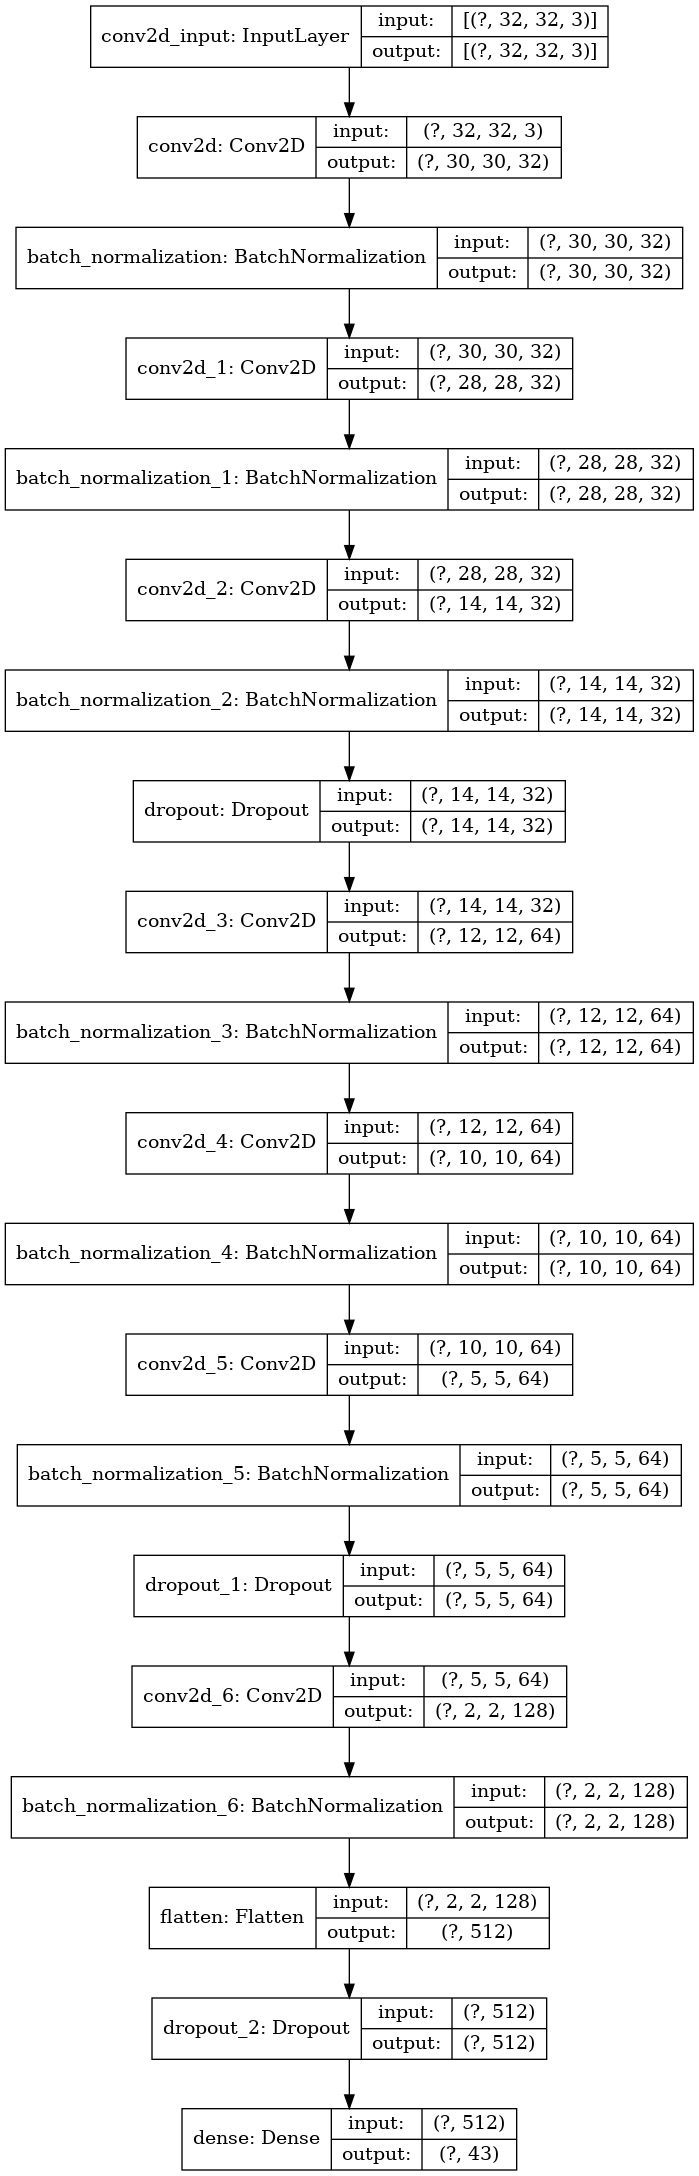

In [5]:
tf.keras.utils.plot_model(model[0], 'diagramaModelo.png', show_shapes=True)

### Tabela do modelo da *Convolutional Neural Network*

<br/>

Processo similar ao anterior mas é mostrado em modo tabela. 

In [6]:
print(model[0].summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0

### Divisão dos *datasets* de Treino e Validação

<br/>

A ideia deste processo consiste em dividir o conjunto de dados massivo fornecido na pasta *train_images*, de modo a conseguirmos obter *datasets* diferentes para o Treino e Validação.
Inicialmente estávamos a usar apenas um *dataset*, sem qualquer divisão, o que não fazia sentido dada a necessidade de treinarmos cada Rede consoante o *dataset* de Treino e Validação.

O **pattern1** é usado para as imagens referentes ao *Validation Datset* e o **pattern2** é usado para as imagens referentes ao *Training Dataset*. Consoante estes patterns, guarda-se em arrays diferentes os paths de cada imagem para que depois possam ser usados na etapa seguinte.

In [7]:
# Arrays para guardar Paths das imagens para cada dataset
training = []
validation = []
totalImagens = 0

# Diretoria Global a ambos os datasets
path = 'gtsrb/train_images/'
dir = os.listdir(path)

pattern1 = '000[0-9]{2}_000(01|02|05|25|27).png'
pattern2 = '.*\.png'

for namePath in dir:
    images = os.listdir(path + namePath)
    for i in images:
        if re.search(pattern1, i):
            validation.append(path + namePath + '/' + i)
            totalImagens += 1
        elif re.search(pattern2, i):
            training.append(path + namePath + '/' + i)
            totalImagens += 1

### Carregar Imagens dos *datasets* de Treino e Validação

<br/>

Esta secção trata de carregar as imagens para os *datasets* de Treino e Validacão.
Como já temos os arrays para o Treino e Validação, executa-se o mesmo processo para ambos.

In [8]:
listDatasetTraining = tf.data.Dataset.list_files(training)
listDatasetValidation = tf.data.Dataset.list_files(validation)

datasetTraining = listDatasetTraining.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
datasetTrainingLength = [i for i,_ in enumerate(datasetTraining)][-1] + 1

datasetValidation = listDatasetValidation.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
datasetValidationLength = [i for i,_ in enumerate(datasetValidation)][-1] + 1

### Preparar os *datasets* de Treino e Validação

<br/>

Preparação dos *datasets* de Treino e Validação.

In [9]:
datasetTraining = datasetTraining.cache()
datasetTraining = datasetTraining.shuffle(buffer_size = datasetTrainingLength)
datasetTraining = datasetTraining.batch(batch_size=batchSize)
datasetTraining = datasetTraining.prefetch(buffer_size=AUTOTUNE)
datasetTraining = datasetTraining.repeat()

datasetValidation = datasetValidation.cache()
datasetValidation = datasetValidation.shuffle(buffer_size = datasetValidationLength)
datasetValidation = datasetValidation.batch(batch_size=batchSize)
datasetValidation = datasetValidation.prefetch(buffer_size=AUTOTUNE)
datasetValidation = datasetValidation.repeat()

### Visualização de algumas Imagens do *dataset* de Treino
<br/>

Demonstração de algumas imagens que estão presetnes no *dataset* de Treino.

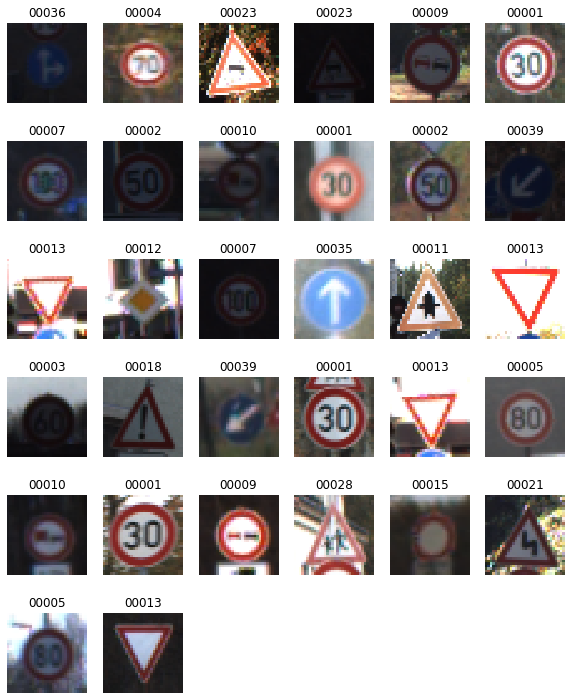

In [10]:
def show_batch(image_batch, label_batch):
  columns = 6
  rows = batchSize / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(batchSize):
      ax = plt.subplot(rows, columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')
        
        
image_batch, label_batch = next(iter(datasetTraining))        
show_batch(image_batch, label_batch.numpy())

### Carregar Imagens e Preparar o *dataset* de Teste
<br/>

Esta secção trata de carregar as imagens para o *dataset* de Teste, executando também o processo de preparação.
Note-se que é mais simples que nos *datasets* anteriores, dado que já existe uma pasta individualizada para este efeito.

In [11]:
datasetTest = tf.data.Dataset.list_files("gtsrb/test_images/*/*.png")

datasetTest = datasetTest.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
datasetTest = datasetTest.batch(batch_size=batchSize)

### Informação acerca do número de Imagens de cada *dataset*

<br/>

Com os três *datasets* totalmente preparados pode ser feito um apanhado geral do conteúdo de cada um deles.

In [12]:
print("Total de imagens presentes na pasta de treino: ", totalImagens)
print("Total de imagens usadas no dataset de treino: ", datasetTrainingLength)
print("Total de imagens usadas no dataset de validação: ", datasetValidationLength)
print("\nTotal de imagens usadas no dataset de teste: ", [i for i,_ in enumerate(datasetTest)][-1] + 1)

Total de imagens presentes na pasta de treino:  39209
Total de imagens usadas no dataset de treino:  32674
Total de imagens usadas no dataset de validação:  6535

Total de imagens usadas no dataset de teste:  395


### Treino de cada *Convolutional Neural Network*

<br/>

É feito o treino para cada um das Redes criadas anteriormente. Neste caso, e conforme já foi referido, estamos apenas a usar uma Rede, pelo que apenas esta será treinada.

Escolhemos 30 *epochs* porque ao fim de alguns testes verificamos que este valor seria o mais indicado para obter o maior valor de *accuracy*. 

**Esta conclusão ficará mais clara depois de observarmos os gráficos que vamos apresentar na secção a seguir.**

In [13]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

history = [0] * nets
epochs = 30

for j in range(nets):
    
    history[j] = model[j].fit(
        datasetTraining,
        steps_per_epoch = datasetTrainingLength/batchSize,
        epochs = epochs,
        validation_data = datasetValidation,
        validation_steps = datasetValidationLength/batchSize
    )

Train for 1021.0625 steps, validate for 204.21875 steps
Epoch 1/30
1022/1021 [==============================] - 14s 14ms/step - loss: 0.6086 - accuracy: 0.8346 - val_loss: 0.1231 - val_accuracy: 0.9663
Epoch 2/30
1022/1021 [==============================] - 9s 9ms/step - loss: 0.1047 - accuracy: 0.9676 - val_loss: 0.1144 - val_accuracy: 0.9691
Epoch 3/30
1022/1021 [==============================] - 9s 9ms/step - loss: 0.0717 - accuracy: 0.9781 - val_loss: 0.0598 - val_accuracy: 0.9822
Epoch 4/30
1022/1021 [==============================] - 9s 9ms/step - loss: 0.0549 - accuracy: 0.9825 - val_loss: 0.0647 - val_accuracy: 0.9792
Epoch 5/30
1022/1021 [==============================] - 9s 9ms/step - loss: 0.0469 - accuracy: 0.9856 - val_loss: 0.0463 - val_accuracy: 0.9876
Epoch 6/30
1022/1021 [==============================] - 9s 9ms/step - loss: 0.0387 - accuracy: 0.9882 - val_loss: 0.0652 - val_accuracy: 0.9798
Epoch 7/30
1022/1021 [==============================] - 9s 9ms/step - loss: 0.

### Gráficos resultados obtidos no treino de cada *Convolutional Neural Network*

<br/>

Esboçamos dois gráficos relativamente aos resultados obtidos para o treino feito em cada Rede. Para cada Rede são desenhados dois gráficos. 

**São eles os seguintes:**

- **Training and Validation Accuracy** permite verificar os valores de *accuracy* no decorrer de cada *epoch*
- **Training and Validation Loss** permite verificar os valores de *loss* no decorrer de cada *epoch*

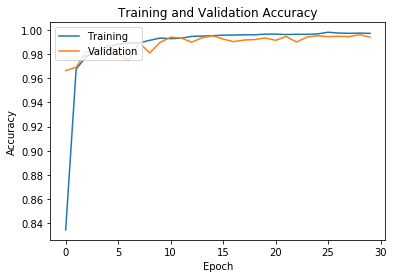

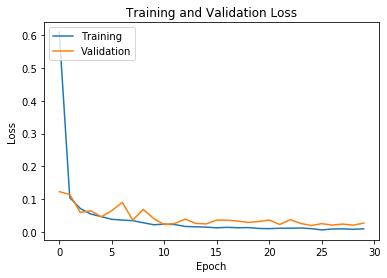

In [14]:
for j in range(nets):
    
    # Summarize History for Accuracy
    plt.plot(history[j].history['accuracy'])
    plt.plot(history[j].history['val_accuracy'])
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

    # Summarize History for Loss
    plt.plot(history[j].history['loss'])
    plt.plot(history[j].history['val_loss'])
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

### Teste de cada *Convolutional Neural Network*

<br/>

Faz-se o teste para cada uma das Redes. Com este teste feito conseguimos obter o valor final de *accuray* que realmente importa para avaliar a precisão do nosso modelo.

In [15]:
for j in range(nets):
    
    model[j].evaluate(datasetTest)

395/395 [==============================] - 2s 4ms/step - loss: 0.1248 - accuracy: 0.9787


### Observações Finais

<br/>

- Inicialmente, sem efetuarmos qualquer alteração ao código obtinhamos uma accuracy de 0.9500, ou seja, 95%
- **Dividindo-se o conjunto de dados para Treino, obtendo-se o *dataset* de Treino e Validação e alterando-se o modelo da rede CNN em si obtemos:**
    - Ao usarmos mais do que uma CNN verificamos que algumas dessas CNNs chegam a ter uma *accuracy* de 0.9800, ou seja, 98%
    - Optando por apenas uma CNN (conforme o resultado acima assim o comprova) obtemos uma accuracy de 0.9787, o que arredondado dá o valor de 98%
- Através dos gráficos acima conseguimos ainda perceber que 30 *epochs* acaba por ser o valor ideal, tanto para a *accuracy* como para o valor de perdas.

Assim, optamos por manter apenas uma CNN, deixando todo o código preparado para fazer o teste para mais de uma (conforme dito já em secções anteriores)

Acreditamos que 98% é um valor excelente para esta primeira fase, dado que a ideia é chegar a 100% com outras técnicas tipicamente usadas como a manipulação dos dados previamente fornecidos.